<a href="https://colab.research.google.com/github/CodeHunterOfficial/AI_DataMining/blob/main/NLP/%D0%9C%D0%BE%D0%B4%D0%B5%D0%BB%D0%B8_%C2%AB%D0%BF%D0%BE%D1%81%D0%BB%D0%B5%D0%B4%D0%BE%D0%B2%D0%B0%D1%82%D0%B5%D0%BB%D1%8C%D0%BD%D0%BE%D1%81%D1%82%D1%8C_%D0%BA_%D0%BF%D0%BE%D1%81%D0%BB%D0%B5%D0%B4%D0%BE%D0%B2%D0%B0%D1%82%D0%B5%D0%BB%D1%8C%D0%BD%D0%BE%D1%81%D1%82%D0%B8%C2%BB_(seq2seq)_%D0%B8_%D0%B2%D0%BD%D0%B8%D0%BC%D0%B0%D0%BD%D0%B8%D0%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Модели «последовательность к последовательности» (seq2seq) и внимание**

Одной из самых популярных задач преобразования последовательностей является машинный перевод, обычно между двумя естественными языками. За последние несколько лет коммерческие системы значительно улучшились, и машинный перевод стал удивительно точным. Примером таких систем являются Google Translate, Yandex Translate, DeepL и Bing Microsoft Translator. Сегодня мы рассмотрим основные компоненты этих систем.


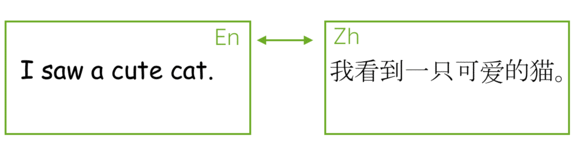


Хотя перевод между естественными языками наиболее известен, модели seq2seq также могут использоваться для преобразования между языками программирования (например, в работе Facebook AI по использованию глубокого обучения для перевода кода) или для преобразования любых последовательностей токенов. Отныне под «машинным переводом» мы будем понимать любую задачу преобразования последовательностей, то есть преобразование одной последовательности токенов в другую, независимо от их природы.

В следующих разделах мы сначала познакомимся с основами моделей seq2seq, затем рассмотрим концепцию внимания — ключевого элемента современных систем — и, наконец, изучим популярную модель Transformer. В процессе мы будем приводить много анализов, упражнений, статей и веселья!



**Основы моделей «последовательность к последовательности»**

Формально, в задаче машинного перевода у нас есть входная последовательность $x_1, x_2, \dots, x_m$ и выходная последовательность $y_1, y_2, \dots, y_n$, где $m$ и $n$ могут быть разной длины. Цель перевода — найти наиболее вероятную целевую последовательность, заданную входными данными. Математически это означает, что мы ищем целевую последовательность, которая максимизирует условную вероятность $p(y | x)$, где:

$$
y^* = \arg\max_y p(y | x)
$$

Если вы двуязычны и можете легко переводить между языками, вы, вероятно, интуитивно понимаете $p(y | x)$. Вы могли бы сказать что-то вроде: «Этот перевод звучит более естественно для этого предложения». В машинном переводе, однако, мы обучаем функцию $p(y | x, \theta)$, где $\theta$ — это параметры модели, а затем находим argmax для заданного входа:

$$
y' = \arg\max_y p(y | x, \theta)
$$



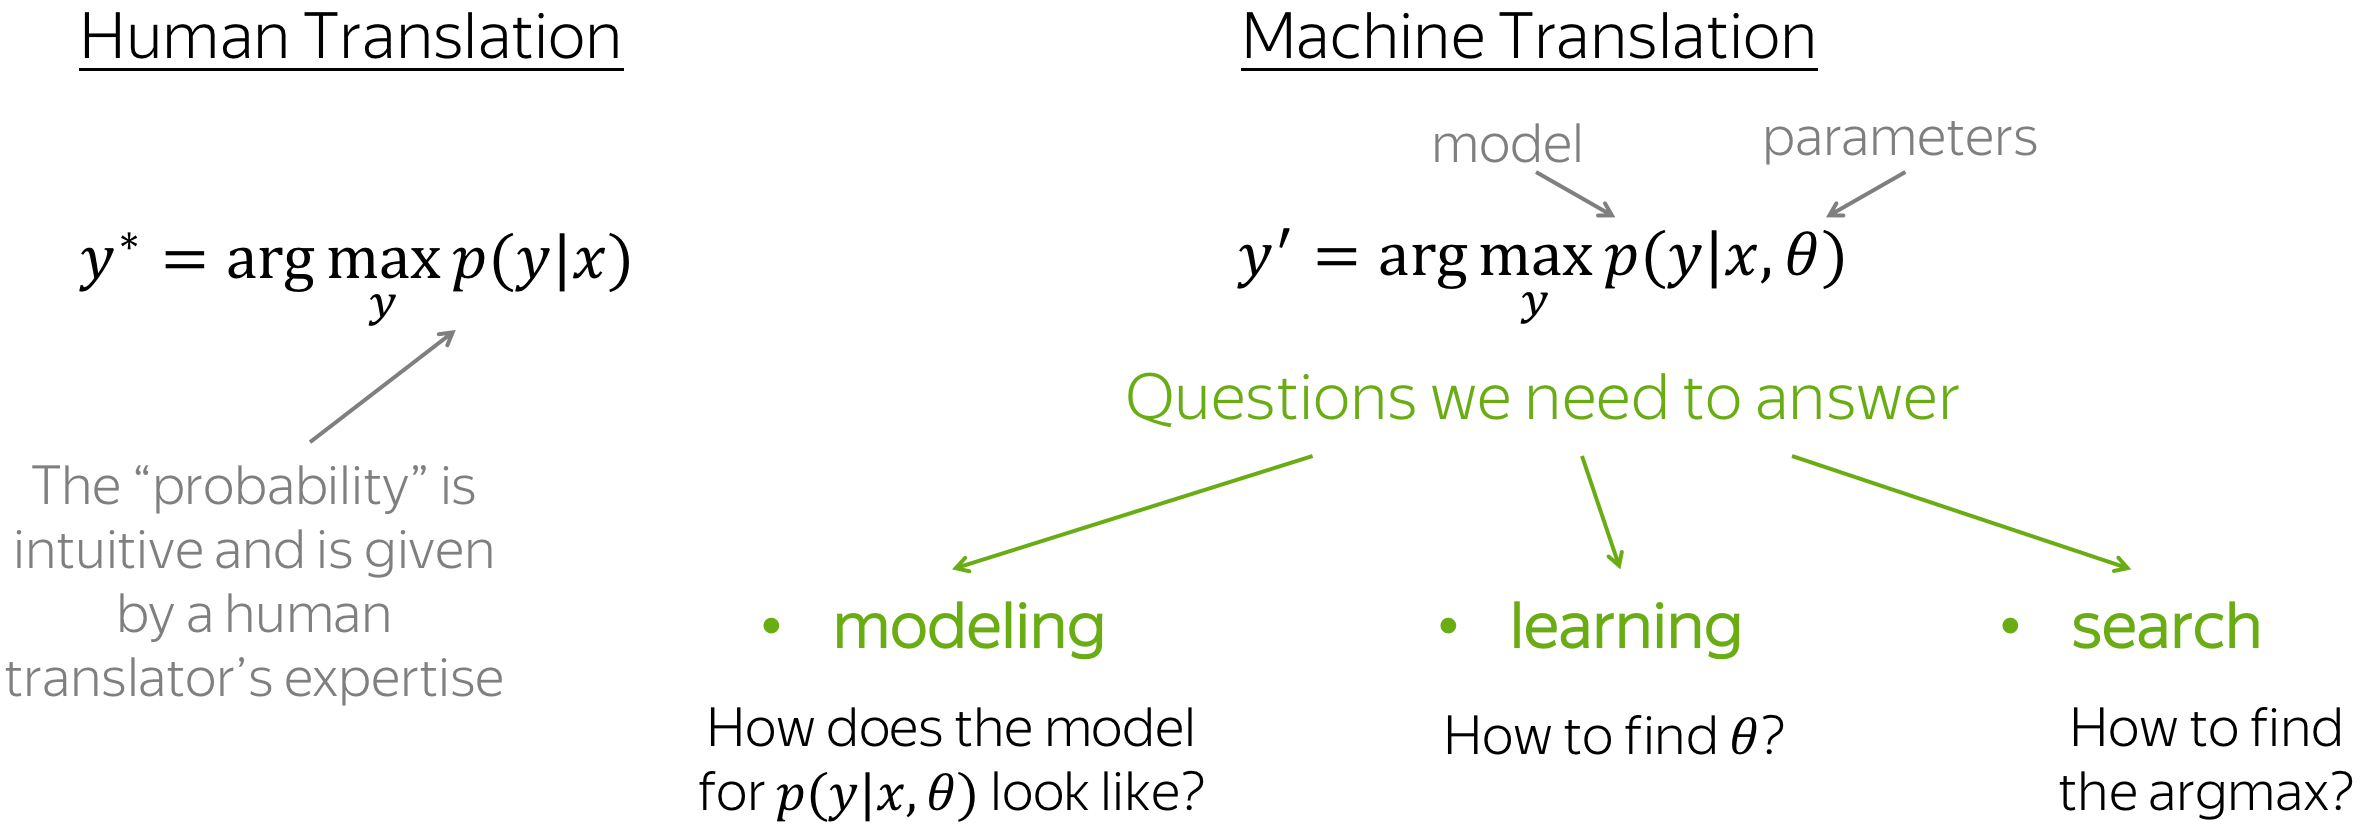

Для того чтобы определить систему машинного перевода, нам нужно ответить на три ключевых вопроса:

1. **Моделирование**: Как выглядит модель для $p(y | x, \theta)$?
2. **Обучение**: Как найти параметры $\theta$?
3. **Инференс**: Как найти лучший $y$?

В этом разделе мы сосредоточимся на ответах на второй и третий вопросы, но будем рассматривать только самую простую модель. Более сложные модели будут рассмотрены в последующих разделах, особенно в разделах, посвященных вниманию и модели Transformer.





**Фреймворк Encoder-Decoder (кодировщик-декодировщик)**

Фреймворк encoder-decoder является стандартной моделью для задач типа последовательность к последовательности. Этот фреймворк состоит из двух компонентов:
- **Кодировщик (encoder)** — читает исходную последовательность и создает её представление.
- **Декодировщик (decoder)** — использует представление, полученное от кодировщика, для генерации целевой последовательности.


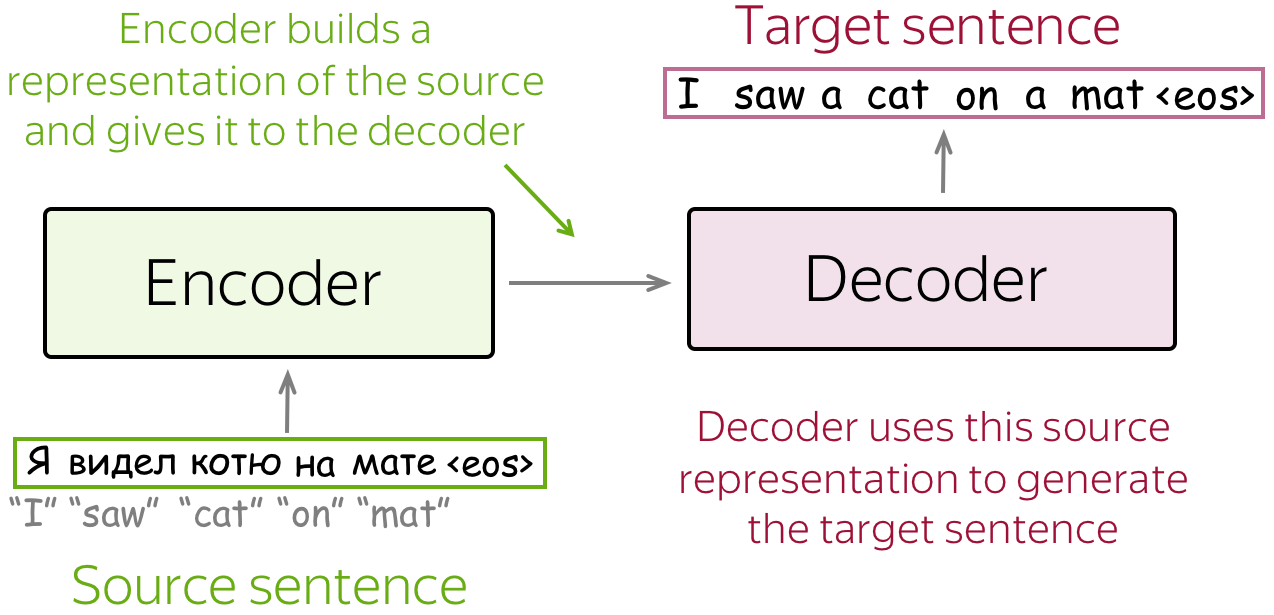


На этой лекции мы рассмотрим различные модели, но все они будут иметь структуру encoder-decoder.

**Условные языковые модели**

В лекции о языковых моделях мы изучали, как оценивать вероятность $p(y)$ последовательности токенов $y = (y_1, y_2, \dots, y_n)$. В то время как языковые модели оценивают безусловную вероятность $p(y)$ последовательности $y$, модели типа последовательность к последовательности должны оценивать условную вероятность $p(y | x)$ последовательности $y$ при условии, что дана исходная последовательность $x$. Поэтому задачи типа последовательность к последовательности могут быть смоделированы как **условные языковые модели (CLM)** — они работают аналогично языковым моделям, но дополнительно принимают исходную информацию $x$.


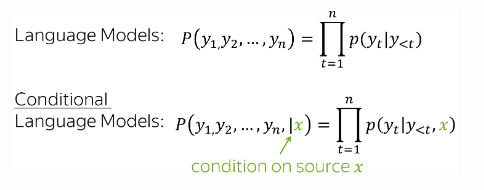


Лена: Обратите внимание, что условное языковое моделирование — это не только способ решения задач типа последовательность к последовательности. В самом общем смысле, $x$ может быть чем-то другим, кроме последовательности токенов. Например, в задаче описания изображений $x$ — это изображение, а $y$ — описание этого изображения.



Поскольку единственное отличие от языковых моделей заключается в наличии источника $x$, моделирование и обучение в целом схожи с языковыми моделями. В частности, высокоуровневый процесс выглядит следующим образом:
- подавать исходные данные и ранее сгенерированные целевые слова в сеть;
- получать векторное представление контекста (как исходного, так и предыдущих целевых данных) из декодировщика сети;
- на основе этого векторного представления предсказывать распределение вероятностей для следующего токена.


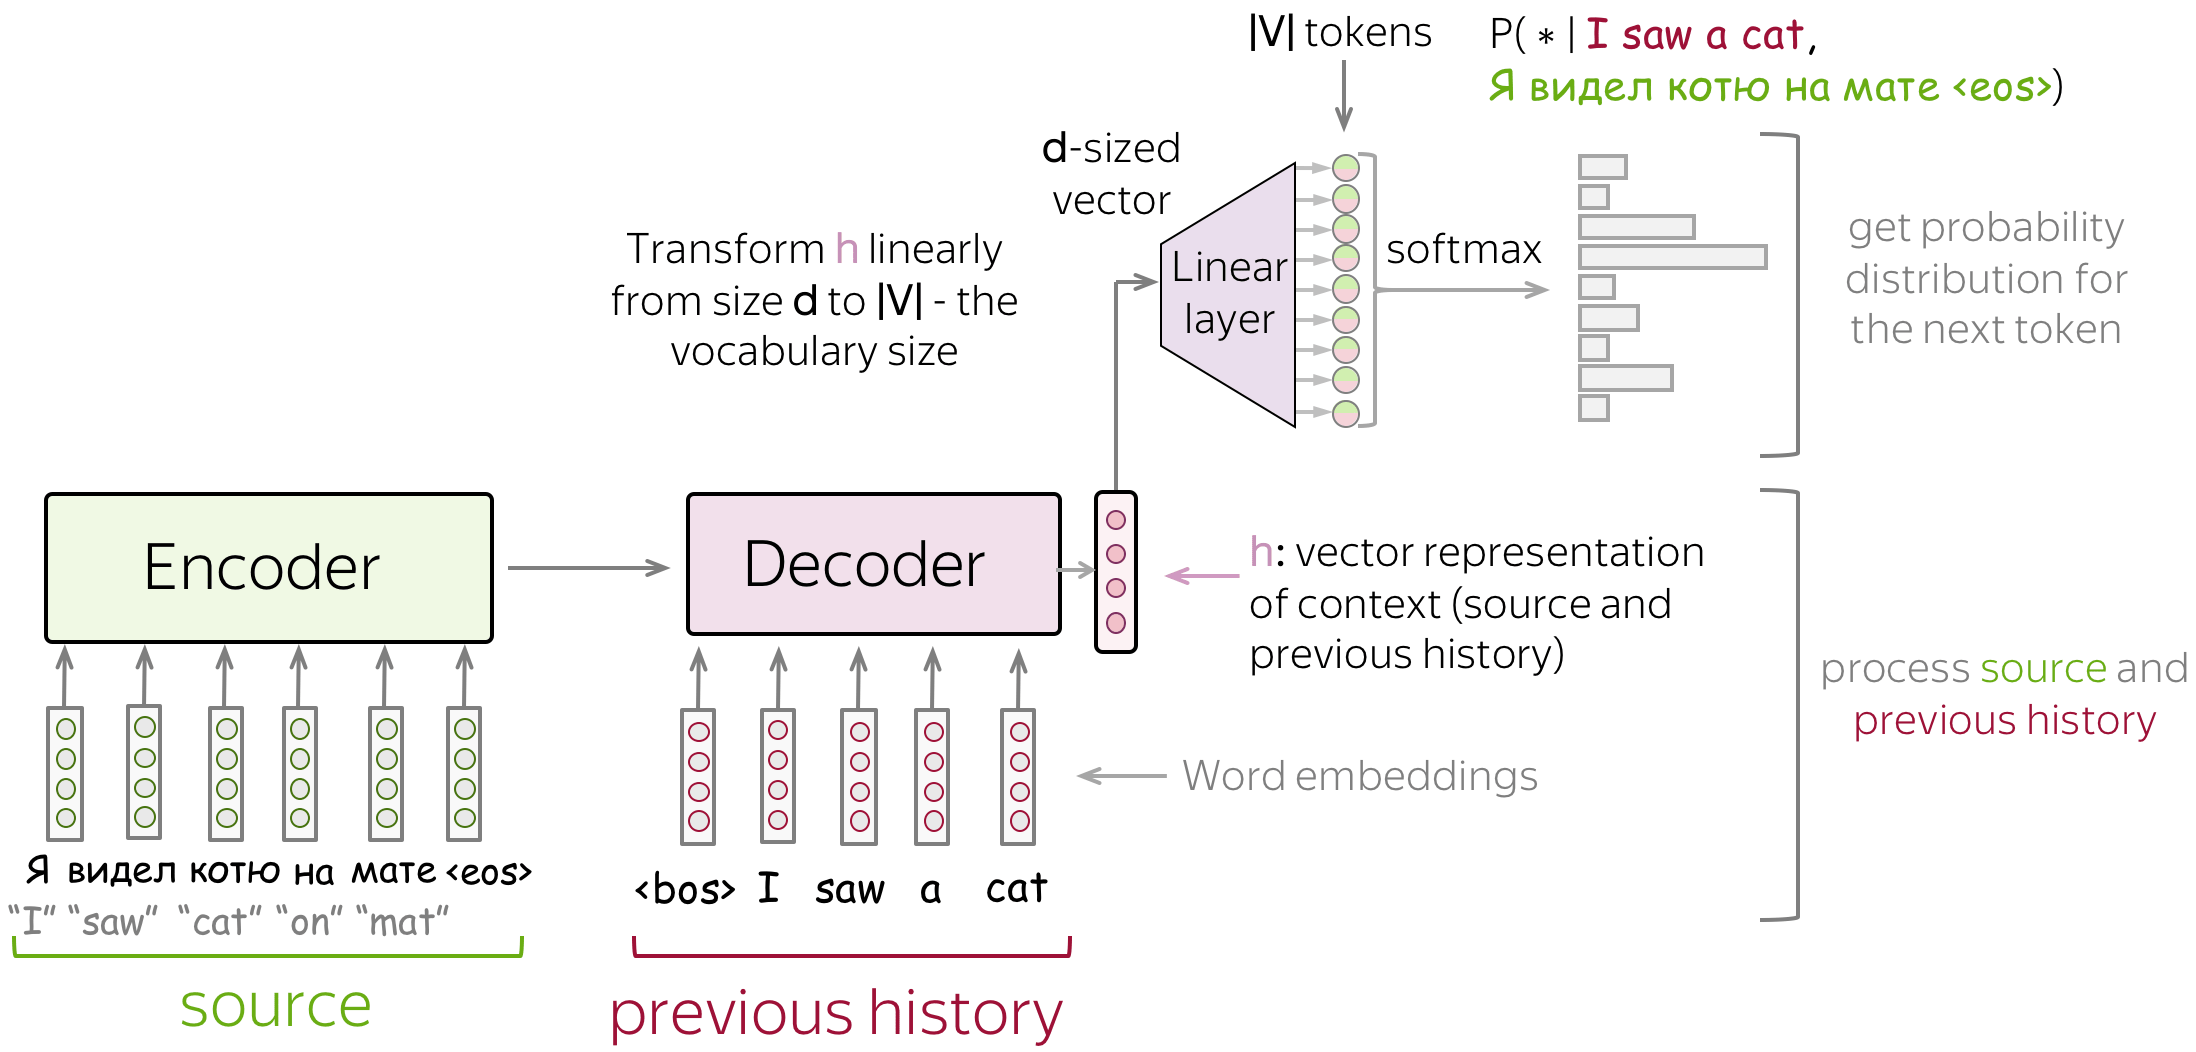




Аналогично нейронным классификаторам и языковым моделям, мы можем рассматривать часть классификации (то есть как получить вероятности токенов из векторного представления текста) очень просто. Векторное представление текста имеет размерность $d$, но в итоге нам нужен вектор размера $|V|$ (вероятности для $|V|$ токенов/классов). Чтобы получить вектор размера $|V|$ из вектора размера $d$, можно использовать линейный слой. Когда у нас есть вектор размера $|V|$, остается только применить операцию softmax, чтобы преобразовать сырые числа в вероятности токенов.